In [1]:
!pip install ultralytics
!pip install omegaconf
!pip install opendatasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.1 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=91187962869ebaa9076b6d8daaec2ae90849c99b153d6a4840fe1afe16b40549
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob as gb
import pickle
import cv2
import torch
import urllib
from tqdm import tqdm
from ultralytics import YOLO
import opendatasets as od

In [ ]:
urllib.request.urlretrieve("https://github.com/akanametov/yolov8-face/releases/download/v0.0.0/yolov8n-face.pt", "yolov8n-face.pt")

('yolov8n-face.pt', <http.client.HTTPMessage at 0x7f61220a6f50>)

In [2]:
yolo_model = YOLO('models/yolov8n-face.pt')

In [ ]:
od.download('https://www.kaggle.com/datasets/imthebaron/cvpr-faces')

Skipping, found downloaded files in "./cvpr-faces" (use force=True to force download)


In [3]:
dataset = 'datasets/Dataset'

In [4]:
os.mkdir('datasets/faces')

In [5]:
faces = 'datasets/faces'

433


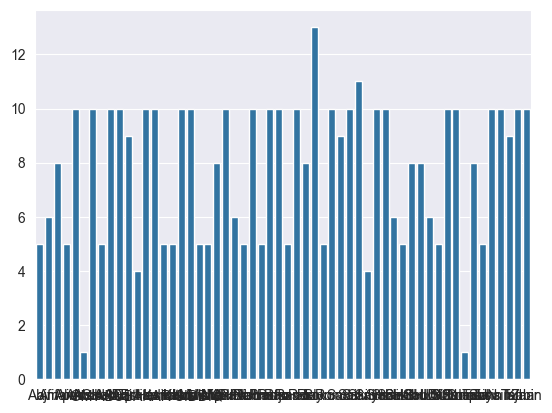

In [6]:
classes = []
class_count = []
train_examples = 0

for f in os.listdir(dataset):
  files = gb.glob(pathname = str(dataset + '//' + f + '//' + '/*'))
  classes.append(f)
  class_count.append(len(files))
  train_examples += len(files)

sns.barplot(x=classes, y=class_count)
print(train_examples)
plt.savefig('barplot.png', dpi=300, bbox_inches='tight')  # Save as PNG with 300 dpi
plt.show()

In [7]:
i = 0
undetected = 0

for c in os.listdir(dataset):
    path = os.path.join(dataset, c)
    folder_path = os.path.join(faces, c)
    os.makedirs(folder_path, exist_ok=True)

    for img in tqdm(os.listdir(path)):
      try:
        face_img = cv2.cvtColor(cv2.imread(os.path.join(path, img)), cv2.COLOR_BGR2RGB)
        results = yolo_model(face_img, verbose=False)

        if len(results[0].boxes) > 0:
          box = results[0].boxes[0].xyxy[0].cpu().numpy().astype(int)
          x_min, y_min, x_max, y_max = box

          face_only = face_img[y_min:y_max, x_min:x_max]

          if face_only.size > 0:
            if face_only.size > 0:
              face_only = cv2.resize(face_only, (720, 720))
              cv2.imwrite(os.path.join(folder_path, img), cv2.cvtColor(face_only, cv2.COLOR_BGR2RGB))
        else:
          print(f'no face detected for {img}')
          undetected += 1

      except Exception as e:
        print(e)

print(f'\ntotal undetected faces: {undetected}')

100%|██████████| 10/10 [00:00<00:00, 13.12it/s]


total undetected faces: 0


In [8]:
len(os.listdir(faces))

56

433


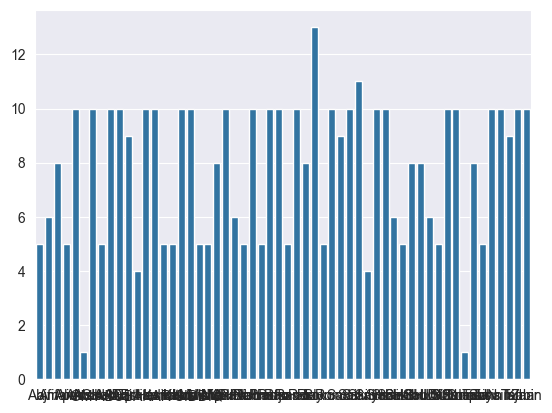

In [9]:
classes = []
class_count = []
train_examples = 0

for f in os.listdir(faces):
  files = gb.glob(pathname = str(faces + '//' + f + '//' + '/*'))
  classes.append(f)
  class_count.append(len(files))
  train_examples += len(files)

sns.barplot(x=classes, y=class_count)
print(train_examples)
plt.savefig('figs/barplot_faces.png', dpi=300, bbox_inches='tight')  # Save as PNG with 300 dpi
plt.show()

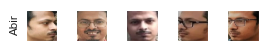

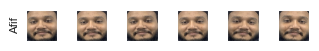

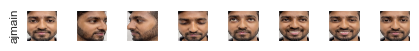

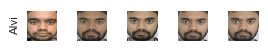

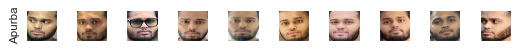

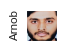

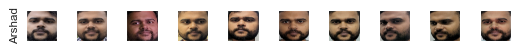

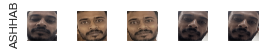

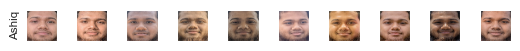

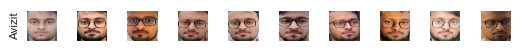

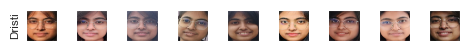

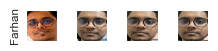

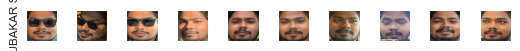

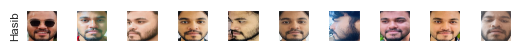

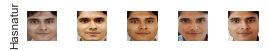

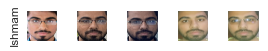

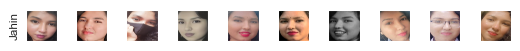

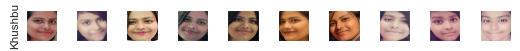

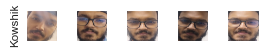

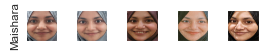

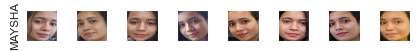

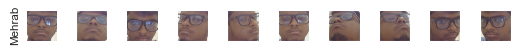

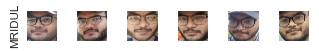

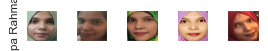

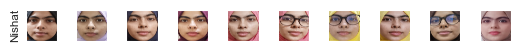

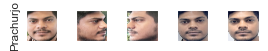

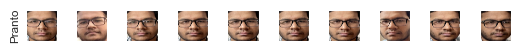

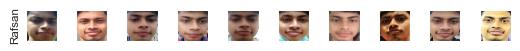

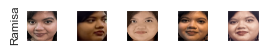

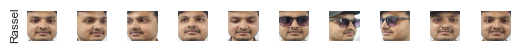

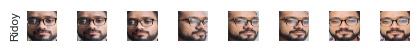

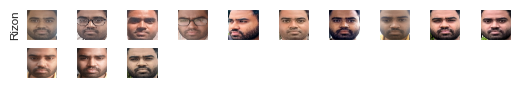

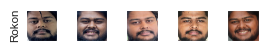

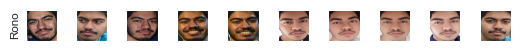

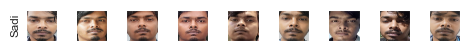

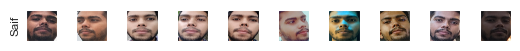

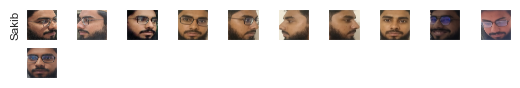

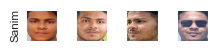

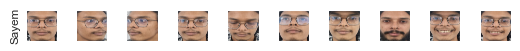

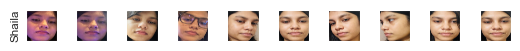

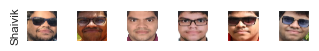

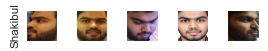

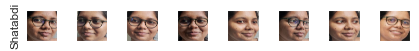

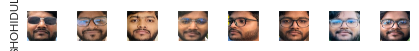

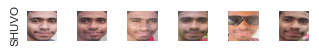

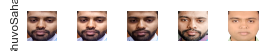

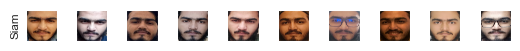

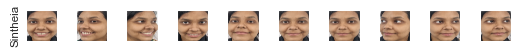

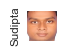

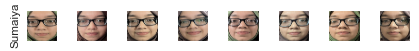

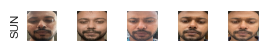

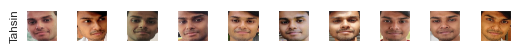

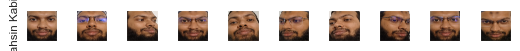

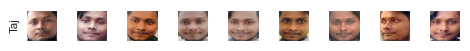

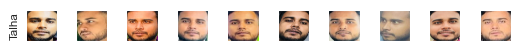

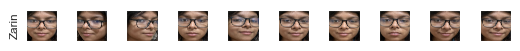

In [10]:
plt.figure()
i = 0

for c in os.listdir(faces):
  path = os.path.join(faces, c)
  for img in os.listdir(path):
    face_img = cv2.cvtColor(cv2.imread(os.path.join(path, img)), cv2.COLOR_BGR2RGB)

    if face_img is not None:
      plt.subplot(10, 10, i+1)
      plt.imshow(face_img)
      if i%15 == 0:
        plt.ylabel(c, size='small')
      plt.xticks([])
      plt.yticks([])
      i += 1

    else:
        print(f'No image at {img}')
  i = 0
  plt.savefig(f'{path}.png', dpi=300, bbox_inches='tight')  # Save as PNG with 300 dpi
  plt.show()

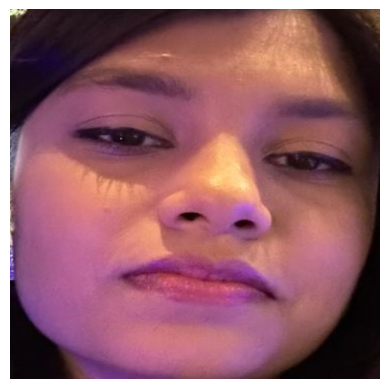

In [11]:
img_rgb = cv2.cvtColor(cv2.imread('datasets/faces/Shaila/WhatsApp Image 2024-09-29 at 16.59.52_7e63eb14.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')  # Optional: Turn off axis
plt.savefig('figs/shaila.png', dpi=400, bbox_inches='tight')  # Save as PNG with 300 dpi
plt.show()

In [12]:
os.mkdir('datasets/augmented_faces')

In [22]:
datagen = ImageDataGenerator(
    rotation_range=20,
    brightness_range=[0.5, 0.8],
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Paths for loading and saving images
original_dir = 'datasets/faces'  # Folder containing class subfolders
save_dir = 'datasets/augmented_faces'  # Folder to save augmented images
target_total_images = 30000  # Total target images after augmentation

# Create the save directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Get total classes in original directory
total_classes = len(os.listdir(original_dir))

# Variable to track total augmented images
total_augmented_images = 0

# Loop over each class folder
# Loop over each class folder
for class_name in os.listdir(original_dir):
    class_dir = os.path.join(original_dir, class_name)

    # Check if class_dir is indeed a directory
    if os.path.isdir(class_dir):
        save_class_dir = os.path.join(save_dir, class_name)

        # Create a folder for the class in the save directory if it doesn't exist
        if not os.path.exists(save_class_dir):
            os.makedirs(save_class_dir)

        # Count the number of images in this class folder
        class_images = os.listdir(class_dir)
        num_class_images = len(class_images)

        # Determine the number of augmented images to generate per image
        images_per_class = target_total_images // total_classes  # Target per class
        images_per_original = max(1, images_per_class // num_class_images)  # Augmented per original image, ensure at least 1

        print(f"Processing class: {class_name} ({num_class_images} images)")

        # Loop through each image in the class folder
        for img_name in tqdm(class_images, desc=f"Augmenting {class_name}", unit="image"):
            img_path = os.path.join(class_dir, img_name)

            # Check if img_path is a valid image file
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = load_img(img_path)  # Load image
                x = img_to_array(img)  # Convert to array
                x = x.reshape((1,) + x.shape)  # Reshape for ImageDataGenerator

                # Generate and save augmented images
                i = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=save_class_dir, save_prefix='aug', save_format='jpeg'):
                    i += 1
                    total_augmented_images += 1  # Increment total augmented images
                    if i >= images_per_original:
                        break  # Stop once the desired number of augmentations is generated for this image

        # Print the total number of augmented images after processing each class
        print()  # Print a new line for better readability
        print(f"Total augmented images so far: {total_augmented_images}")

# Final total augmented images after all classes
print(f"Total augmented images generated: {total_augmented_images}")

Processing class: Abir (5 images)


Augmenting Abir: 100%|██████████| 5/5 [00:18<00:00,  3.68s/image]



Total augmented images so far: 265
Processing class: Afif (6 images)


Augmenting Afif: 100%|██████████| 6/6 [00:18<00:00,  3.02s/image]



Total augmented images so far: 529
Processing class: ajmain (8 images)


Augmenting ajmain: 100%|██████████| 8/8 [00:17<00:00,  2.18s/image]



Total augmented images so far: 793
Processing class: Alvi (5 images)


Augmenting Alvi: 100%|██████████| 5/5 [00:17<00:00,  3.49s/image]



Total augmented images so far: 1058
Processing class: Apurba (10 images)


Augmenting Apurba: 100%|██████████| 10/10 [00:17<00:00,  1.71s/image]



Total augmented images so far: 1318
Processing class: Arnob (1 images)


Augmenting Arnob: 100%|██████████| 1/1 [00:17<00:00, 17.69s/image]



Total augmented images so far: 1585
Processing class: Arshad (10 images)


Augmenting Arshad: 100%|██████████| 10/10 [00:17<00:00,  1.77s/image]



Total augmented images so far: 1845
Processing class: ASHHAB (5 images)


Augmenting ASHHAB: 100%|██████████| 5/5 [00:18<00:00,  3.64s/image]



Total augmented images so far: 2110
Processing class: Ashiq (10 images)


Augmenting Ashiq: 100%|██████████| 10/10 [00:19<00:00,  1.91s/image]



Total augmented images so far: 2370
Processing class: Avizit (10 images)


Augmenting Avizit: 100%|██████████| 10/10 [00:18<00:00,  1.81s/image]



Total augmented images so far: 2630
Processing class: Dristi (9 images)


Augmenting Dristi: 100%|██████████| 9/9 [00:18<00:00,  2.03s/image]



Total augmented images so far: 2891
Processing class: Farhan (4 images)


Augmenting Farhan: 100%|██████████| 4/4 [00:18<00:00,  4.56s/image]



Total augmented images so far: 3155
Processing class: GM ABUBAKAR SIDDIQ (10 images)


Augmenting GM ABUBAKAR SIDDIQ: 100%|██████████| 10/10 [00:17<00:00,  1.78s/image]



Total augmented images so far: 3415
Processing class: Hasib (10 images)


Augmenting Hasib: 100%|██████████| 10/10 [00:17<00:00,  1.78s/image]



Total augmented images so far: 3675
Processing class: Hasnatur (5 images)


Augmenting Hasnatur: 100%|██████████| 5/5 [00:17<00:00,  3.55s/image]



Total augmented images so far: 3940
Processing class: Ishmam (5 images)


Augmenting Ishmam: 100%|██████████| 5/5 [00:17<00:00,  3.59s/image]



Total augmented images so far: 4205
Processing class: Jahin (10 images)


Augmenting Jahin: 100%|██████████| 10/10 [00:17<00:00,  1.79s/image]



Total augmented images so far: 4465
Processing class: Khushbu (10 images)


Augmenting Khushbu: 100%|██████████| 10/10 [00:17<00:00,  1.79s/image]



Total augmented images so far: 4725
Processing class: Kowshik (5 images)


Augmenting Kowshik: 100%|██████████| 5/5 [00:18<00:00,  3.72s/image]



Total augmented images so far: 4990
Processing class: Maishara (5 images)


Augmenting Maishara: 100%|██████████| 5/5 [00:17<00:00,  3.48s/image]



Total augmented images so far: 5255
Processing class: MAYSHA (8 images)


Augmenting MAYSHA: 100%|██████████| 8/8 [00:17<00:00,  2.18s/image]



Total augmented images so far: 5519
Processing class: Mehrab (10 images)


Augmenting Mehrab: 100%|██████████| 10/10 [00:17<00:00,  1.73s/image]



Total augmented images so far: 5779
Processing class: MRIDUL (6 images)


Augmenting MRIDUL: 100%|██████████| 6/6 [00:17<00:00,  2.93s/image]



Total augmented images so far: 6043
Processing class: Nipa Rahman (5 images)


Augmenting Nipa Rahman: 100%|██████████| 5/5 [00:17<00:00,  3.51s/image]



Total augmented images so far: 6308
Processing class: Nishat (10 images)


Augmenting Nishat: 100%|██████████| 10/10 [00:17<00:00,  1.78s/image]



Total augmented images so far: 6568
Processing class: Prachurjo (5 images)


Augmenting Prachurjo: 100%|██████████| 5/5 [00:18<00:00,  3.67s/image]



Total augmented images so far: 6833
Processing class: Pranto (10 images)


Augmenting Pranto: 100%|██████████| 10/10 [00:18<00:00,  1.81s/image]



Total augmented images so far: 7093
Processing class: Rafsan (10 images)


Augmenting Rafsan: 100%|██████████| 10/10 [00:17<00:00,  1.79s/image]



Total augmented images so far: 7353
Processing class: Ramisa (5 images)


Augmenting Ramisa: 100%|██████████| 5/5 [00:18<00:00,  3.75s/image]



Total augmented images so far: 7618
Processing class: Rassel (10 images)


Augmenting Rassel: 100%|██████████| 10/10 [00:18<00:00,  1.83s/image]



Total augmented images so far: 7878
Processing class: Ridoy (8 images)


Augmenting Ridoy: 100%|██████████| 8/8 [00:18<00:00,  2.29s/image]



Total augmented images so far: 8142
Processing class: Rizon (13 images)


Augmenting Rizon: 100%|██████████| 13/13 [00:18<00:00,  1.42s/image]



Total augmented images so far: 8402
Processing class: Rokon (5 images)


Augmenting Rokon: 100%|██████████| 5/5 [00:18<00:00,  3.72s/image]



Total augmented images so far: 8667
Processing class: Rono (10 images)


Augmenting Rono: 100%|██████████| 10/10 [00:18<00:00,  1.86s/image]



Total augmented images so far: 8927
Processing class: Sadi (9 images)


Augmenting Sadi: 100%|██████████| 9/9 [00:18<00:00,  2.09s/image]



Total augmented images so far: 9188
Processing class: Saif (10 images)


Augmenting Saif: 100%|██████████| 10/10 [00:17<00:00,  1.71s/image]



Total augmented images so far: 9448
Processing class: Sakib (11 images)


Augmenting Sakib: 100%|██████████| 11/11 [00:17<00:00,  1.62s/image]



Total augmented images so far: 9712
Processing class: Sanim (4 images)


Augmenting Sanim: 100%|██████████| 4/4 [00:17<00:00,  4.37s/image]



Total augmented images so far: 9976
Processing class: Sayem (10 images)


Augmenting Sayem: 100%|██████████| 10/10 [00:17<00:00,  1.75s/image]



Total augmented images so far: 10236
Processing class: Shaila (10 images)


Augmenting Shaila: 100%|██████████| 10/10 [00:17<00:00,  1.77s/image]



Total augmented images so far: 10496
Processing class: Shaivik (6 images)


Augmenting Shaivik: 100%|██████████| 6/6 [00:17<00:00,  2.95s/image]



Total augmented images so far: 10760
Processing class: Shakibul (5 images)


Augmenting Shakibul: 100%|██████████| 5/5 [00:18<00:00,  3.64s/image]



Total augmented images so far: 11025
Processing class: Shatabdi (8 images)


Augmenting Shatabdi: 100%|██████████| 8/8 [00:18<00:00,  2.29s/image]



Total augmented images so far: 11289
Processing class: SHOHIDUL (8 images)


Augmenting SHOHIDUL: 100%|██████████| 8/8 [00:18<00:00,  2.26s/image]



Total augmented images so far: 11553
Processing class: SHUVO (6 images)


Augmenting SHUVO: 100%|██████████| 6/6 [00:18<00:00,  3.03s/image]



Total augmented images so far: 11817
Processing class: ShuvoSaha (5 images)


Augmenting ShuvoSaha: 100%|██████████| 5/5 [00:18<00:00,  3.74s/image]



Total augmented images so far: 12082
Processing class: Siam (10 images)


Augmenting Siam: 100%|██████████| 10/10 [00:18<00:00,  1.85s/image]



Total augmented images so far: 12342
Processing class: Sintheia (10 images)


Augmenting Sintheia: 100%|██████████| 10/10 [00:18<00:00,  1.83s/image]



Total augmented images so far: 12602
Processing class: Sudipta (1 images)


Augmenting Sudipta: 100%|██████████| 1/1 [00:18<00:00, 18.53s/image]



Total augmented images so far: 12869
Processing class: Sumaiya (8 images)


Augmenting Sumaiya: 100%|██████████| 8/8 [00:18<00:00,  2.30s/image]



Total augmented images so far: 13133
Processing class: SUN (5 images)


Augmenting SUN: 100%|██████████| 5/5 [00:18<00:00,  3.77s/image]



Total augmented images so far: 13398
Processing class: Tahsin (10 images)


Augmenting Tahsin: 100%|██████████| 10/10 [00:18<00:00,  1.83s/image]



Total augmented images so far: 13658
Processing class: Tahsin Kabir (10 images)


Augmenting Tahsin Kabir: 100%|██████████| 10/10 [00:18<00:00,  1.80s/image]



Total augmented images so far: 13918
Processing class: Taj (9 images)


Augmenting Taj: 100%|██████████| 9/9 [00:17<00:00,  1.91s/image]



Total augmented images so far: 14179
Processing class: Talha (10 images)


Augmenting Talha: 100%|██████████| 10/10 [00:17<00:00,  1.72s/image]



Total augmented images so far: 14439
Processing class: Zarin (10 images)


Augmenting Zarin: 100%|██████████| 10/10 [00:17<00:00,  1.74s/image]


Total augmented images so far: 14699
Total augmented images generated: 14699


241


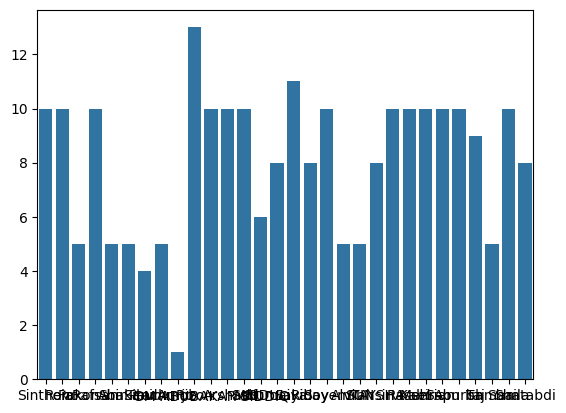

In [ ]:
classes = []
class_count = []
train_examples = 0

for f in os.listdir('/content/augmented faces'):
  files = gb.glob(pathname = str(faces + '//' + f + '//' + '/*'))
  classes.append(f)
  class_count.append(len(files))
  train_examples += len(files)

sns.barplot(x=classes, y=class_count)
print(train_examples)

In [ ]:
# import shutil
# shutil.rmtree('/content/augmented_faces')